In [2]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open("./names.txt", 'r').read().splitlines()

In [4]:
words[:3]

['emma', 'olivia', 'ava']

In [5]:
min(len(w) for w in words)

2

In [6]:
max(len(w) for w in words)

15

In [7]:
chars = sorted(list(set(''.join(words))))

In [8]:
N = torch.zeros((27, 27), dtype=torch.int32)
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [9]:
# model smoothing
N += 5

In [10]:
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1,ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

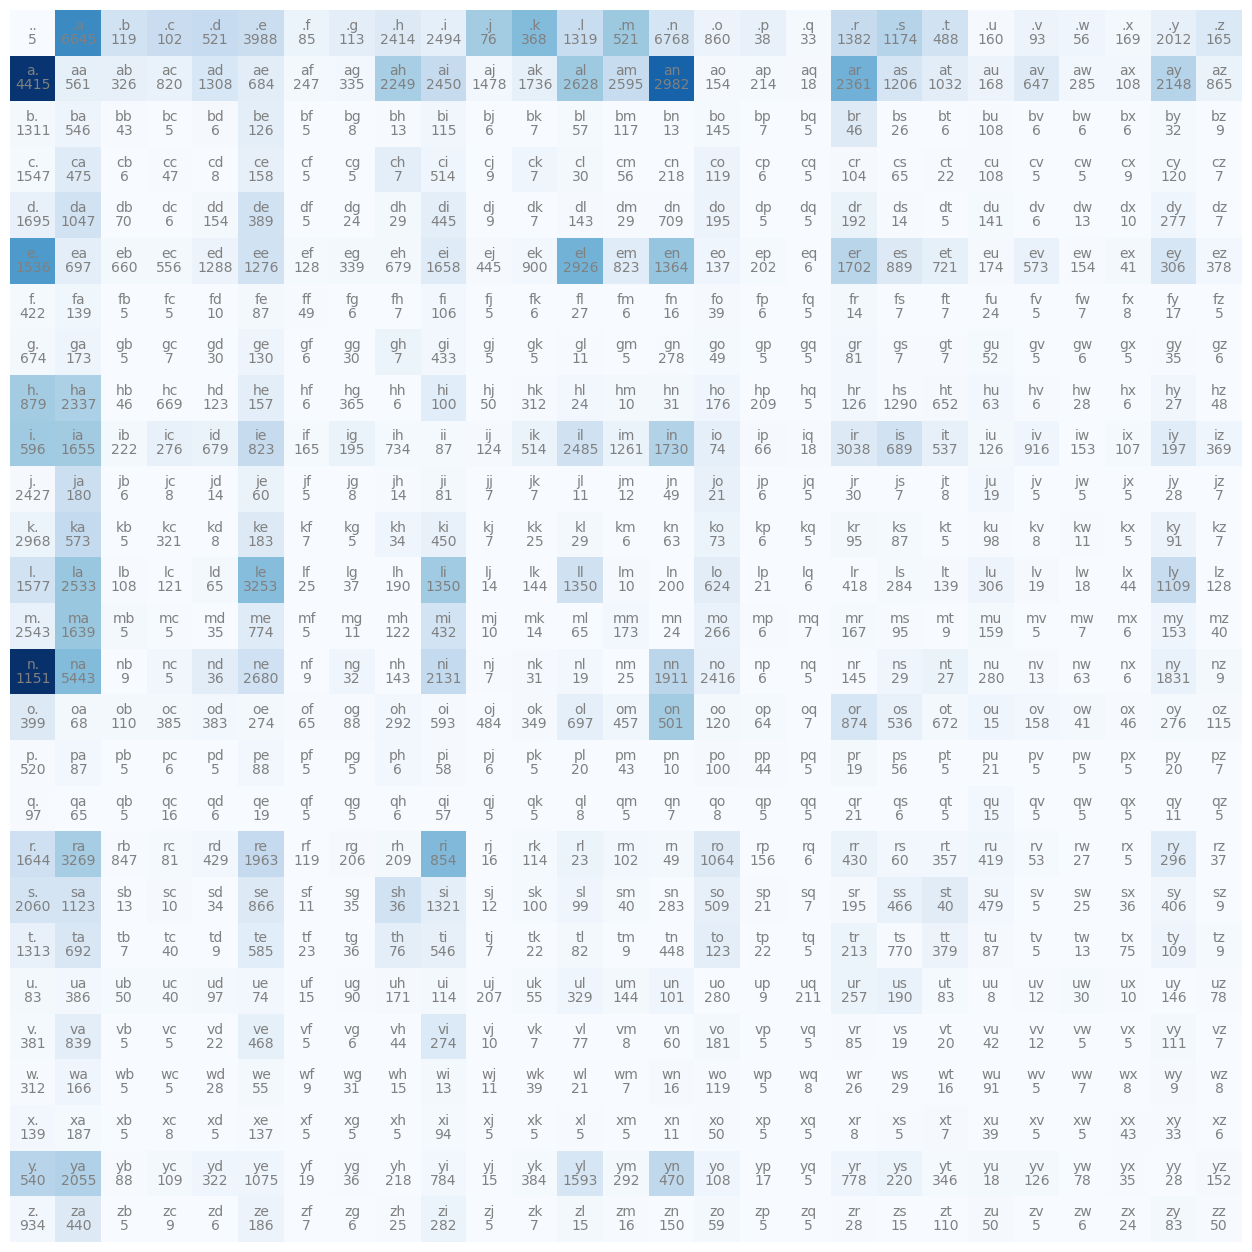

In [11]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap="Blues")
for i in range(27):
  for j in range(27):
    chstr = itos[i] + itos[j]
    plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
    plt.text(j, i, str(N[j, i].item()), ha="center", va="top", color="gray")

plt.axis('off');

In [12]:
p = N[0]
p = p / p.sum()

In [13]:
g = torch.Generator().manual_seed(2147483647)
torch.multinomial(p, num_samples=100, replacement=True, generator=g)

tensor([13, 19, 14,  1,  1, 21, 20,  1, 13, 13, 13, 11, 23, 13, 19, 18, 26, 11,
         7, 19,  1, 11, 18, 10, 11, 15,  2,  9, 18,  2,  5,  3,  1, 13, 11, 11,
        22, 11, 15, 26,  2, 18, 13, 10,  1, 15,  2,  3, 15, 10, 12,  4,  9,  3,
         4,  6,  4, 19, 10,  3,  8,  4, 10, 13, 14, 13, 10, 19, 11,  8, 13,  5,
         5,  6, 25, 20, 10, 18,  1,  8,  3,  2, 20,  1,  1,  3, 10, 11, 25, 18,
         1,  9, 11,  8, 12,  3, 12, 19,  9, 18])

In [14]:
P = N.float()
P /= P.sum(1, keepdim=True)

In [15]:
P[9].sum()

tensor(1.)

In [16]:
g = torch.Generator().manual_seed(2147483647)
for i in range(20):
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juwe.
ksahnaauranilevias.
dedainrwieta.
ssonielylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabdinerimikimaynin.
anaasn.
ssorionsush.


In [17]:
n = 0
log_likelihood = 0.0
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1,ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    # print(f"{ch1}{ch2}: {prob:.4f} {logprob:.4f}")
  
# print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
print(f"{nll/n:.4f}")

nll=tensor(560645.1875)
2.4574


### Neural network

In [18]:
import torch.nn.functional as F

In [19]:
xs, ys = [], []
for w in words[:1]:
  chs = ["."] + list(w) + ["."]
  for ch1,ch2 in zip(chs,chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [20]:
xs

tensor([ 0,  5, 13, 13,  1])

In [30]:
ys

tensor([ 5, 13, 13,  1,  0])

In [21]:
xenc = F.one_hot(torch.tensor(xs), num_classes=27).float()

/tmp/ipykernel_8452/3467125841.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xenc = F.one_hot(torch.tensor(xs), num_classes=27).float()


In [32]:
xenc.shape

torch.Size([5, 27])

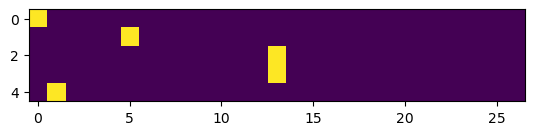

In [22]:
plt.imshow(xenc)

In [23]:
w = torch.randn((27,27), dtype=torch.float32)
(xenc@w).shape

torch.Size([5, 27])

In [24]:
(xenc@w)[3][13]

tensor(0.2343)

In [25]:
logits = xenc @ w
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)

In [26]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [27]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
loss = -probs[torch.arange(5), ys].log().mean()

In [28]:
#backward pass
W.grad = None
loss.backward()

# update params
W.data += -1 * W.grad

In [29]:
loss.item()

3.7693049907684326

In [34]:
# everything above but again
# -------
# create dataset
xs, ys = [], []
for w in words:
  chs = ["."] + list(w) + ["."]
  for ch1,ch2 in zip(chs,chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)

xs = torch.tensor(xs)    
ys = torch.tensor(ys)

# initialize neural net
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [38]:
xs, ys

(tensor([ 0,  5, 13,  ..., 25, 26, 24]),
 tensor([ 5, 13, 13,  ..., 26, 24,  0]))

In [39]:
F.one_hot(xs, num_classes=27).shape

torch.Size([228146, 27])

In [30]:
# gradient descent
for _ in range(150):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float()
  logits = xenc @ W
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdim=True)
  loss = -probs[torch.arange(xs.nelement()), ys].log().mean() + 0.01*(W**2).mean()

  print(loss.item())

  # backward pass
  W.grad = None
  loss.backward()
  W.data += -50 * W.grad


3.8637783527374268
3.435811758041382
3.192918062210083


3.0426182746887207
2.9402544498443604
2.866541862487793
2.8116488456726074
2.7693328857421875
2.7357146739959717
2.7083561420440674
2.685664176940918
2.666562795639038
2.650298595428467
2.6363229751586914
2.624216318130493
2.6136512756347656
2.6043665409088135
2.5961523056030273
2.5888404846191406
2.5822947025299072
2.5764048099517822
2.571080446243286
2.5662472248077393
2.561842918395996
2.5578157901763916
2.5541205406188965
2.55072021484375
2.5475809574127197
2.5446760654449463
2.541980504989624
2.5394723415374756
2.5371341705322266
2.53494930267334
2.532902956008911
2.5309832096099854
2.5291783809661865
2.5274789333343506
2.525876045227051
2.524362087249756
2.5229296684265137
2.5215723514556885
2.520285129547119
2.5190625190734863
2.517899751663208
2.5167925357818604
2.515737295150757
2.514730453491211
2.5137686729431152
2.5128493309020996
2.5119686126708984
2.511125326156616
2.510316848754883
2.5095410346984863
2.508795738220215
2.5080792903900146
2.507389545440674
2.50672578811645

In [31]:
# sampling from the network
g = torch.Generator().manual_seed(2147483647)
for i in range(15):
  out = []
  ix = 0
  while True:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)

    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
janasah.
prelay.
a.
nn.
kohin.
tolian.
juwe.
ksahnaauranilevias.
dedainrwieta.
ssonielylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
